# Fraud Detection Using Binary Classification

In [1]:
# Import modules
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import json

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [2]:
# Import Data
df = pd.read_csv('drive/My Drive/zz_fraud_detection/fraud_data.csv')

In [3]:
df.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0


In [4]:
df.isna().sum() # No missing data points

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

# Setup data for Machine Learning Model

In [5]:
df_temp = df.copy()
df_temp.drop(['nameOrig','nameDest'],axis=1, inplace=True)
df_temp.head(5)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [6]:
# Turn categorical variables into numbers
for label, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # # Add binary column to inidicate whether sample had missing value
        # df_temp[label+"_is_missing"] = pd.isnull(content)
        # missing categories set as -1
        df_temp[label] = pd.Categorical(content).codes + 1  

In [7]:
print(df_temp.head(5)) # Check new data
print(df_temp['isFlaggedFraud'].unique()) # Make sure there are some flagged

   step  type    amount  ...  newbalanceDest  isFraud  isFlaggedFraud
0     1     4   9839.64  ...             0.0        0               0
1     1     4   1864.28  ...             0.0        0               0
2     1     5    181.00  ...             0.0        1               0
3     1     2    181.00  ...             0.0        1               0
4     1     4  11668.14  ...             0.0        0               0

[5 rows x 9 columns]
[0 1]


In [8]:
X = df_temp.drop('isFraud',axis=1)
y = df_temp['isFraud']

In [9]:
print(X.head(3))
print(y.head(3))

   step  type   amount  ...  oldbalanceDest  newbalanceDest  isFlaggedFraud
0     1     4  9839.64  ...             0.0             0.0               0
1     1     4  1864.28  ...             0.0             0.0               0
2     1     5   181.00  ...             0.0             0.0               0

[3 rows x 8 columns]
0    0
1    0
2    1
Name: isFraud, dtype: int64


In [10]:
# Split Data into Trainding and Testing Sets (using first 1000 due to large amount of data)
X_train, X_test, y_train, y_test = train_test_split(X[:100000], y[:100000], test_size=0.2)

# Train Binary Classification Model
* Unsure what model to use so will test 3 different types
  * KNN, Logistic Regression, and Random Forest

In [11]:
# Store Model Types
model_types = {"KNN": KNeighborsClassifier(),
               "Logistic Regression": LogisticRegression(), 
               "Random Forest": RandomForestClassifier()}

# Create function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models = a dict of different Scikit-Learn machine learning models
    X_train = training data
    X_test = testing data
    y_train = targets for training
    y_test = targets for test data
    """
    # Random seed for reproducible results
    np.random.seed(1)
    model_scores = {} # Stores Scores

    for name, model in models.items():
        model.fit(X_train, y_train) # Fit Model
        model_scores[name] = model.score(X_test, y_test) # Evaluation
    return model_scores

In [12]:
# Model Runtime ~
model_scores = fit_and_score(model_types, X_train, X_test, y_train, y_test) 
model_scores

{'KNN': 0.99875, 'Logistic Regression': 0.99905, 'Random Forest': 0.99925}

In [13]:
model_svc = svm.SVC()
model_svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [14]:
model_svc.score(X_test, y_test)

0.99875

All models preformed well. Random Forest Classifier is selected for further testing

# Test Best Model

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2) # Setup model for all data
best_model = RandomForestClassifier()
best_model.fit(X_train2, y_train2)

In [16]:
best_model.score(X_test2, y_test2) # Checking best model score on all data

0.9997123826348265

In [17]:
os.chdir('/content/drive/My Drive/zz_fraud_detection')
# pickle.dump(best_model, open('model_1.pkl','wb')) # Save model for future use
load_model = pickle.load(open('model_1.pkl','rb'))

In [18]:
y_pred = load_model.predict(X_test2)
y_prob = load_model.predict_proba(X_test2)
cross_val_score(load_model, X, y)

array([0.99938312, 0.99963458, 0.9914312 , 0.99931003, 0.02203338])

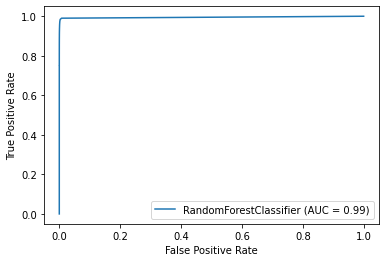

In [19]:
plot_roc_curve(load_model, X_test2, y_test2)

In [21]:
print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270897
           1       0.98      0.80      0.88      1627

    accuracy                           1.00   1272524
   macro avg       0.99      0.90      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524

